In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import matplotlib.pyplot as plt

tf.random.set_seed(0)
np.random.seed(0)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17206666878332651837
xla_global_id: -1
]


2023-08-16 10:13:44.991275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 10:13:44.991429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Creating the dataset

In [2]:
num_samples = 10000
num_dimensions = 30

# Generate random samples
raw_data = np.random.rand(num_samples, num_dimensions)

outlier_indices_1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
outlyin_amount_1 = 20
outlier_indices_2 = [0,2,4,6,8,10,12]
outlyin_amount_2 = 10
outlier_indices_3 = [0,3,6,9,12,15,18]
outlyin_amount_3 = 5
outlier_indices_4 = [0,4,8,12,16,20,24]
outlyin_amount_4 = 2
outlier_indices_5 = [0,5,10,15,20,25,29]
outlyin_amount_5 = 1.1
outlier_indices_6 = [0,1,2,3,4,5,6]
outlyin_amount_6 = [20,15,10,5,2,1.1,1.05]

corrupted_data = raw_data

corrupted_data[100:120, outlier_indices_1] = outlyin_amount_1
corrupted_data[200:220, outlier_indices_2] = outlyin_amount_2
corrupted_data[300:320, outlier_indices_3] = outlyin_amount_3
corrupted_data[400:420, outlier_indices_4] = outlyin_amount_4
corrupted_data[500:520, outlier_indices_5] = outlyin_amount_5
corrupted_data[600:620, outlier_indices_6] = outlyin_amount_6

for outlier_gene_index in range(corrupted_data.shape[1]+1):
    corrupted_data[700+outlier_gene_index,:outlier_gene_index] = outlyin_amount_1
    

# print(raw_data)

In [24]:
corrupted_data[101]

array([2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.33105498e-01, 6.22835255e-02, 4.32449093e-02,
       9.17770980e-01, 1.77630992e-01, 8.51370529e-01, 4.10909857e-01,
       1.80974552e-01, 3.31971558e-01, 7.13295425e-01, 6.81479132e-01,
       9.65109346e-02, 1.47411256e-01, 3.40297727e-01, 5.37056299e-01,
       2.11464300e-01, 5.36157327e-01, 5.79639725e-01, 7.62368311e-01,
       1.38144855e-01, 8.03941816e-01, 1.54198474e-01, 8.70276335e-01,
       8.84306064e-01, 2.62646529e-01, 9.12050413e-01, 4.90728195e-01,
       2.20559204e-01, 6.89516993e-01, 4.74984146e-03, 6.49720262e-01,
       6.87216803e-01, 6.88775382e-01, 8.58165239e-01, 7.33863273e-01,
      

# Training the VAE

In [10]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 64

encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(256, activation="tanh")(encoder_inputs)
x = layers.Dense(128, activation="tanh")(x)
x = layers.Dense(64, activation="tanh")(x)
x = layers.Dense(32, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(32, activation="tanh")(latent_inputs)
x = layers.Dense(64, activation="tanh")(x)
x = layers.Dense(128, activation="tanh")(x)
x = layers.Dense(256, activation="tanh")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.1 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

creditdata = np.concatenate([corrupted_data], axis=0)
creditdata = np.expand_dims(creditdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = vae.fit(creditdata, epochs=100, batch_size=512)

Epoch 1/100
20/20 [==============================] - 1s 4ms/step - loss: 2.4654 - reconstruction_loss: 2.2980 - kl_loss: 0.2122
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 2.1276 - reconstruction_loss: 2.1457 - kl_loss: 0.1413
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 2.0922 - reconstruction_loss: 2.1255 - kl_loss: 0.1387
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 2.0532 - reconstruction_loss: 2.0960 - kl_loss: 0.1454
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 2.1499 - reconstruction_loss: 2.0778 - kl_loss: 0.1402
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 2.1474 - reconstruction_loss: 2.0750 - kl_loss: 0.1261
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 2.1556 - reconstruction_loss: 2.0781 - kl_loss: 0.1106
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 2.3023 - reconstruction_loss: 2

20/20 [==============================] - 0s 4ms/step - loss: 2.1372 - reconstruction_loss: 2.0781 - kl_loss: 0.0132
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 2.4057 - reconstruction_loss: 2.1341 - kl_loss: 0.0124
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 2.0914 - reconstruction_loss: 2.0804 - kl_loss: 0.0119
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 2.2249 - reconstruction_loss: 2.0480 - kl_loss: 0.0118
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 2.3015 - reconstruction_loss: 2.0731 - kl_loss: 0.0113
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 2.2648 - reconstruction_loss: 2.0527 - kl_loss: 0.0124
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 2.2089 - reconstruction_loss: 2.1121 - kl_loss: 0.0115
Epoch 71/100
20/20 [==============================] - 0s 4ms/step - loss: 1.9167 - reconstruction_loss: 2.1558

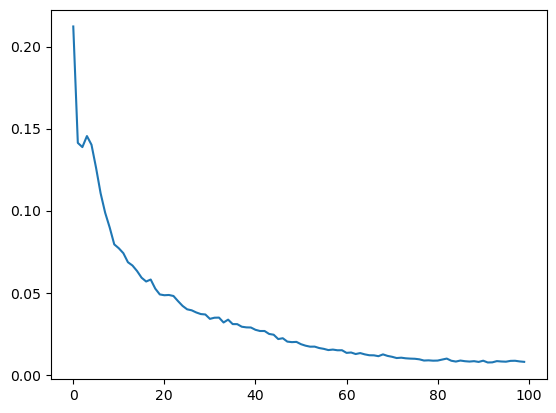

In [15]:
plt.plot(history.history["kl_loss"])

In [4]:
out_1 = corrupted_data[100:120, :] 
out_2 = corrupted_data[200:220, :] 
out_3 = corrupted_data[300:320, :] 
out_4 = corrupted_data[400:420, :]
out_5 = corrupted_data[500:520, :] 
# out_6 = corrupted_data[600:620, :]
# out_7 = corrupted_data[700:730, :]
 
# all_outlier = np.concatenate((out_1, out_2, out_3, out_4, out_5, out_6, out_7), axis=0)
# all_outlier = np.concatenate((out_1, out_2), axis=0)

out_rec = []

for i in range(out_1.shape[0]):
    
    outlier1 = out_1[i,:].reshape([1,num_dimensions])

    z_mean, z_log_var, z = vae.encoder(outlier1)
    reconstruction = vae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(outlier1,reconstruction)
    out_rec.append(reconstruction_loss.numpy())

out_mean = np.mean(np.array(out_rec))
out_std = np.std(np.array(out_rec))

print("Mean = ", out_mean)
print("Std = ", out_std)

Mean =  76.07617
Std =  0.025529306


In [13]:
out_rec

[84.465164,
 84.71406,
 84.48756,
 84.45812,
 84.817986,
 84.46852,
 84.44194,
 84.495995,
 84.466354,
 84.44945,
 84.45529,
 84.55129,
 84.4003,
 84.47173,
 84.52946,
 84.60273,
 84.52152,
 84.53423,
 84.4844,
 84.54963,
 19.113712,
 19.157207,
 19.138416,
 19.18679,
 19.11386,
 19.157316,
 19.161037,
 19.289093,
 19.084723,
 19.140812,
 19.12425,
 19.336569,
 19.163595,
 19.212496,
 19.08789,
 19.128956,
 19.290602,
 19.112019,
 19.1702,
 19.190197,
 3.9667118,
 4.052538,
 3.981691,
 4.1402645,
 3.9902778,
 3.9949865,
 3.966025,
 3.9998052,
 3.9884753,
 3.9420161,
 3.9186776,
 3.9855304,
 3.922363,
 4.131799,
 4.010767,
 3.9884064,
 4.015008,
 4.250755,
 3.9889631,
 4.026939,
 0.39450216,
 0.44092643,
 0.51412356,
 0.5443928,
 0.46769777,
 0.46737248,
 0.514566,
 0.46590763,
 0.4434161,
 0.55226445,
 0.5244426,
 0.4680444,
 0.52104026,
 0.5422156,
 0.46453506,
 0.4585864,
 0.4885511,
 0.48057434,
 0.532297,
 0.46126837,
 0.107018866,
 0.12909862,
 0.17025925,
 0.16684014,
 0.1334761,

The error calculation for setting the threshold

In [74]:
inliers = corrupted_data[5:80,:]
mean_data = np.mean(corrupted_data, axis=0)
outlier1 = corrupted_data[101,:]



# #------------------ replacing the genes here ---------------------

# inliers[:,1] = mean_data[1]

# outlier1[1] = mean_data[1]

# # ----------------------------------------------------------------

ouliers_mean_error = []

for i in range(20):
    
    mean_mean = []
    
    for step in range(10):
        
        outlier1 = corrupted_data[100 + i,:]
        
        outlier1[10] = mean_data[10]

        outlier1 = outlier1.reshape([1,num_dimensions])

        z_mean, z_log_var, z = vae.encoder(outlier1)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(outlier1,reconstruction)

#         print(reconstruction_loss.numpy())

        mean_mean.append(reconstruction_loss.numpy())

#     print("MEAN_MEAN = ", i, np.mean(np.array(mean_mean)))
#     print("std_MEAN = ", i, np.std(np.array(mean_mean)))
    
    ouliers_mean_error.append(np.mean(np.array(mean_mean)))

print(ouliers_mean_error)
print(np.mean(np.array(ouliers_mean_error)))

[72.493546, 72.43561, 72.47243, 72.498024, 72.50472, 72.444496, 72.46104, 72.43702, 72.44527, 72.48209, 72.50123, 72.491486, 72.493614, 72.462875, 72.46201, 72.46493, 72.41083, 72.4693, 72.42071, 72.503265]
72.46772


In [75]:
mean_mean = []

for step in range(10):

    mean_ins_error = []

    for index in range(inliers.shape[0]):

        cand = inliers[index,:]

        cand = cand.reshape([1,num_dimensions])

        mean_data = mean_data.reshape([1,num_dimensions])

        z_mean, z_log_var, z = vae.encoder(cand)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(cand,reconstruction)

        mean_ins_error.append(reconstruction_loss.numpy())

    #     print("MEAN", index, " = ", reconstruction_loss.numpy())

    mean_ins_error = np.array(mean_ins_error)
    print("mean = ", np.mean(mean_ins_error))
    
    mean_mean.append(np.mean(mean_ins_error))
    

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

mean =  0.08414489
mean =  0.08581538
mean =  0.08437245
mean =  0.084212355
mean =  0.08434542
mean =  0.0842573
mean =  0.08464338
mean =  0.08425837
mean =  0.08397871
mean =  0.08448286
MEAN_MEAN =  0.08445111
std_MEAN =  0.00048633362


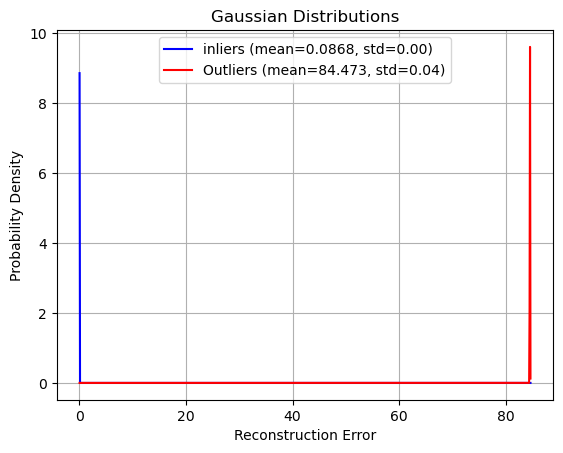

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage:
mean2 = 84.473
std2 = 0.035
mean1 = 0.0868
std1 = 0.0005

def gaussian(x, mean, std):
    """
    Compute the Gaussian probability density function.

    Parameters:
        x (numpy array): The input values.
        mean (float): Mean of the Gaussian distribution.
        std (float): Standard deviation of the Gaussian distribution.

    Returns:
        numpy array: The Gaussian probability density function values.
    """
    exponent = -0.5 * ((x - mean) / std)**2
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exponent)

def plot_gaussian(mean1, std1, mean2, std2):
    """
    Plot two Gaussian distributions with given means and standard deviations.

    Parameters:
        mean1 (float): Mean of the first Gaussian distribution.
        std1 (float): Standard deviation of the first Gaussian distribution.
        mean2 (float): Mean of the second Gaussian distribution.
        std2 (float): Standard deviation of the second Gaussian distribution.

    Returns:
        None
    """
    x = np.linspace(min(mean1 - 3 * std1, mean2 - 3 * std2), max(mean1 + 3 * std1, mean2 + 3 * std2), 1000)
    gaussian1 = gaussian(x, mean1, std1)
    gaussian2 = gaussian(x, mean2, std2)

    plt.plot(x, gaussian1, label=f"inliers (mean={mean1}, std={std1:.2f})", color='blue')
    plt.plot(x, gaussian2, label=f"Outliers (mean={mean2}, std={std2:.2f})", color='red')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Probability Density')
    plt.title('Gaussian Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_gaussian(mean1, std1, mean2, std2)


Setting the threshold and trying to detect the outliers:

In [ ]:
for item_no in range(corrupted_data.shape[0]):
    
    candidate_sample = corrupted_data[item_no,:]
    candidate_sample = candidate_sample.reshape([1,30])
    
    z_mean, z_log_var, z = vae.encoder(candidate_sample)
    reconstruction = vae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(candidate_sample,reconstruction)
    
    if reconstruction_loss.numpy() > 1:
        
        print("An Outlier Detected on sample No. ", item_no)

# Genetic Part

In [48]:

def fitness_func_avg(ga_instance, solution, solution_idx):
    
    inliers = corrupted_data[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,num_dimensions])
    
    particle = corrupted_data[101,:]
    particle = particle.reshape([1,num_dimensions])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    mean_fit = []
    
    for reapeat in range(5):

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,num_dimensions])

            in_remain = candidate_inlier * solution

            in_normal_subspace = 1 - solution

            in_replace = in_normal_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z_mean, z_log_var, z = vae.encoder(in_candidate)
            in_candidate_rec = vae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_remain = particle * solution

        out_normal_subspace = 1 - solution

        out_replace = avg_ins * out_normal_subspace

        out_candidate = out_remain + out_replace


        z_mean, z_log_var, z = vae.encoder(out_candidate)
        out_candidate_rec = vae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = rec_loss / avg_in_rec
        
        mean_fit.append(fitness)
    
    mean_fit = np.array(mean_fit)
    mean_fit = np.mean(mean_fit)
    
    return mean_fit


def fitness_func_avg_with_penalty(ga_instance, solution, solution_idx):
    
    inliers = corrupted_data[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,num_dimensions])
    
    particle = corrupted_data[201,:]
    particle = particle.reshape([1,num_dimensions])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,num_dimensions])
        
        in_remain = candidate_inlier * solution
        
        in_normal_subspace = 1 - solution
        
        in_replace = in_normal_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)
    
    out_remain = particle * solution
    
    out_normal_subspace = 1 - solution
    
    out_replace = avg_ins * out_normal_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    # adding the penalty here!
    
    num_ones = np.count_nonzero(solution == 1)
    
    penalty_rate = 1.0/corrupted_data.shape[1]
    
    fitness = fitness - num_ones * penalty_rate * fitness
    
    return fitness

def on_generation(ga):
    print("Generation", ga.generations_completed)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    print(solution_fitness)


fitness_function = fitness_func_avg

num_generations = 100
num_parents_mating = 2

sol_per_pop = 100
num_genes = corrupted_data.shape[1]

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

space = [[0,1] for i in range(num_genes)]

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 1
mutation_probability = 0.01

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
#                        mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       mutation_probability = mutation_probability,
                       gene_space = space)

In [49]:
ga_instance.run()

Generation 1
1060.9261
Generation 2
1132.9841
Generation 3
1177.5522
Generation 4
1211.5306
Generation 5
1291.9257
Generation 6
1337.1437
Generation 7
1407.2747
Generation 8
1417.3425
Generation 9
1453.8658
Generation 10
1488.9908
Generation 11
1504.596
Generation 12
1535.6776
Generation 13
1546.3848
Generation 14
1569.9551
Generation 15
1592.6697
Generation 16
1614.9974
Generation 17
1637.351
Generation 18
1664.75
Generation 19
1670.592
Generation 20
1678.265
Generation 21
1683.6797
Generation 22
1699.3453
Generation 23
1700.8477
Generation 24
1700.8477
Generation 25
1731.3871
Generation 26
1738.3806
Generation 27
1773.5918
Generation 28
1774.5627
Generation 29
1795.5465
Generation 30
1774.1791
Generation 31
1774.1791
Generation 32
1794.0564
Generation 33
1774.4729
Generation 34
1784.4652
Generation 35
1793.8545
Generation 36
1800.884
Generation 37
1808.3279
Generation 38
1808.3279
Generation 39
1808.3279
Generation 40
1808.3279
Generation 41
1815.7727
Generation 42
1813.4885
Generati

In [50]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Fitness value of the best solution = 1851.3616943359375


In [44]:
my_sol = np.zeros((1,num_dimensions))
my_sol[0,outlier_indices_1] = 1

# my_sol = solution 

inliers = corrupted_data[10:13,:]
    
avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,num_dimensions])

particle = corrupted_data[101,:]
particle = particle.reshape([1,num_dimensions])

#     abn_subspace = solution * val_features[6728,:]

#     abn_subspace = abn_subspace.reshape([1,30])

avg_in_rec = []

for index in range(inliers.shape[0]):

    candidate_inlier = inliers[index,:]
    candidate_inlier = candidate_inlier.reshape([1,num_dimensions])

    in_remain = candidate_inlier * my_sol

    in_normal_subspace = 1 - my_sol

    in_replace = in_normal_subspace * avg_ins

    in_candidate = in_remain + in_replace

    z_mean, z_log_var, z = vae.encoder(in_candidate)
    in_candidate_rec = vae.decoder(z)


    rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

    avg_in_rec.append(rec_loss.numpy())

avg_in_rec = np.array(avg_in_rec)
avg_in_rec = np.mean(avg_in_rec)





#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

out_remain = particle * my_sol

out_normal_subspace = 1 - my_sol

out_replace = avg_ins * out_normal_subspace

out_candidate = out_remain + out_replace


z_mean, z_log_var, z = vae.encoder(out_candidate)
out_candidate_rec = vae.decoder(z)

rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
rec_loss = rec_loss.numpy()

fitness = rec_loss / avg_in_rec

In [45]:
fitness

1867.0812

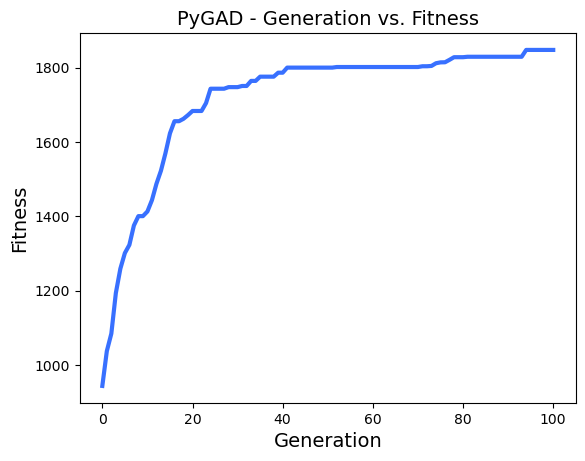

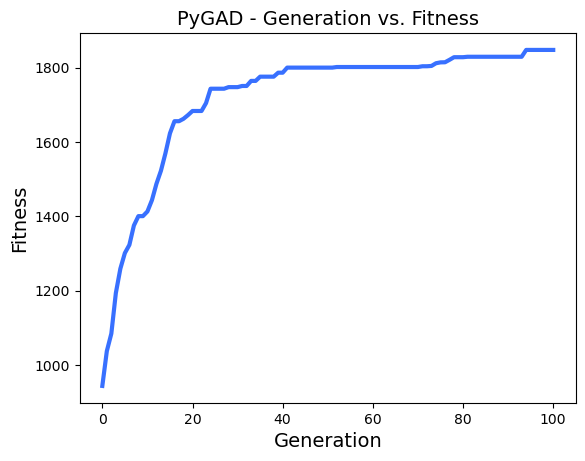

In [16]:
ga_instance.plot_fitness()

# For loop for Genetic Algorithms

In [ ]:
best_solutions = []

wandb.init(
    # set the wandb project where this run will be logged
    project="VAE_Outlier_GA_Without_Penalty_KL_fixed_out=10",
    
    # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 20,
#     }
)

for out_indexing in range(1,corrupted_data.shape[1]+1):
    
    def fitness_func_avg(ga_instance, solution, solution_idx):

        inliers = corrupted_data[10:13,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,30])

        particle = corrupted_data[700+out_indexing,:]
        particle = particle.reshape([1,30])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,30])

            in_remain = candidate_inlier * solution

            in_normal_subspace = 1 - solution

            in_replace = in_normal_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z_mean, z_log_var, z = vae.encoder(in_candidate)
            in_candidate_rec = vae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_remain = particle * solution

        out_normal_subspace = 1 - solution

        out_replace = avg_ins * out_normal_subspace

        out_candidate = out_remain + out_replace


        z_mean, z_log_var, z = vae.encoder(out_candidate)
        out_candidate_rec = vae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = rec_loss / avg_in_rec

        return fitness
    
    def fitness_func_avg_with_penalty(ga_instance, solution, solution_idx):
    
        inliers = corrupted_data[10:13,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,30])

        particle = corrupted_data[700+out_indexing,:]
        particle = particle.reshape([1,30])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,30])

            in_remain = candidate_inlier * solution

            in_normal_subspace = 1 - solution

            in_replace = in_normal_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z_mean, z_log_var, z = vae.encoder(in_candidate)
            in_candidate_rec = vae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_remain = particle * solution

        out_normal_subspace = 1 - solution

        out_replace = avg_ins * out_normal_subspace

        out_candidate = out_remain + out_replace


        z_mean, z_log_var, z = vae.encoder(out_candidate)
        out_candidate_rec = vae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        # adding the penalty here!

        num_ones = np.count_nonzero(solution == 1)

        penalty_rate = 1.0 / corrupted_data.shape[1]
        
        regul_param = 10
        
        penalty_rate = penalty_rate / regul_param
        
        fitness = rec_loss / (avg_in_rec + (num_ones * penalty_rate * avg_in_rec))

#         fitness = fitness - num_ones * penalty_rate * fitness

        return fitness

    def on_generation(ga):
        print("Generation", ga.generations_completed)

        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        
        wandb.log({"GA - " + str(out_indexing) + "/solution_fitness": solution_fitness})

        print(solution_fitness)


    fitness_function = fitness_func_avg

    num_generations = 40
    num_parents_mating = 4

    sol_per_pop = 100
    num_genes = corrupted_data.shape[1]

    init_range_low = -2
    init_range_high = 5

    parent_selection_type = "sss"
    keep_parents = 1

    space = [[0,1] for i in range(num_genes)]

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
#                            keep_parents=keep_parents,
                           keep_elitism=2,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           on_generation=on_generation,
                           gene_space = space)

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("##########  End of the ", out_indexing, " epoch ##########")
    print("Parameters of the best solution : {solution}".format(solution=solution))

    best_solutions.append(solution)
    
    sample = corrupted_data[700+out_indexing,:]
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for gene_no in range(30):
        
        if ((sample[gene_no] == 20) and (solution[gene_no] == 1)):
            
            TP = TP + 1
        
        elif (sample[gene_no] != 20) and (solution[gene_no] == 1):
            
            FP = FP + 1
            
        elif (sample[gene_no] != 20) and (solution[gene_no] == 0):
            
            TN = TN + 1
            
        elif (sample[gene_no] == 20) and (solution[gene_no] == 0):
            
            FN = FN + 1
    
    precision = TP / (TP + FP)

    recall = TP / (TP + FN)

    F1 = 2 * (precision * recall)/(precision + recall)
    
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    wandb.log({"Metrics/precision": precision, 
               "Metrics/recall": recall,
               "Metrics/F1": F1,
               "Metrics/MCC": MCC,
               "Metrics/num": out_indexing})
    
best_solutions = np.array(best_solutions)
np.save('best_solutions.npy', best_solutions)

GA - 1/solution_fitness,▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
GA - 2/solution_fitness,▁▂▃▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
GA - 3/solution_fitness,▁▅▇▇█████
Metrics/F1,█▁
Metrics/MCC,█▁
Metrics/num,▁█
Metrics/precision,█▁
Metrics/recall,▁▁
GA - 1/solution_fitness,82.37335
GA - 2/solution_fitness,159.17348
GA - 3/solution_fitness,218.34586


Generation 1
69.882645
Generation 2
75.792885
Generation 3
79.13617
Generation 4
80.04578
Generation 5
79.852066
Generation 6
79.852066
Generation 7
79.852066
Generation 8
80.85276
Generation 9
83.29973
Generation 10
83.034996
Generation 11
83.034996
Generation 12
83.034996
Generation 13
83.034996
Generation 14
83.034996
Generation 15
83.034996
Generation 16
83.034996
Generation 17
83.56759
Generation 18
83.034996
Generation 19
83.034996
Generation 20
83.034996
Generation 21
83.034996
Generation 22
83.034996
Generation 23
83.034996
Generation 24
83.034996
Generation 25
83.034996
Generation 26
83.034996
Generation 27
83.034996
Generation 28
83.034996
Generation 29
83.034996
Generation 30
83.034996
Generation 31
83.034996
Generation 32
83.034996
Generation 33
83.034996
Generation 34
83.034996
Generation 35
83.034996
Generation 36
83.034996
Generation 37
83.034996
Generation 38
83.034996
Generation 39
83.034996
Generation 40
83.034996
##########  End of the  1  epoch ##########
Parameters

485.54114
Generation 19
485.54114
Generation 20
485.54114
Generation 21
485.54114
Generation 22
485.54114
Generation 23
485.54114
Generation 24
485.54114
Generation 25
485.54114
Generation 26
485.54114
Generation 27
485.54114
Generation 28
485.54114
Generation 29
485.54114
Generation 30
485.54114
Generation 31
485.54114
Generation 32
485.54114
Generation 33
485.54114
Generation 34
485.54114
Generation 35
485.54114
Generation 36
485.54114
Generation 37
485.54114
Generation 38
485.54114
Generation 39
485.54114
Generation 40
485.54114
##########  End of the  8  epoch ##########
Parameters of the best solution : [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0.]
Generation 1
440.33078
Generation 2
503.82397
Generation 3
510.32172
Generation 4
512.2069
Generation 5
511.86075
Generation 6
511.86075
Generation 7
537.15796
Generation 8
537.15796
Generation 9
537.15796
Generation 10
537.15796
Generation 11
537.15796
Generation 12
537.15796
Generation 13

749.1935
Generation 37
749.1935
Generation 38
749.1935
Generation 39
749.1935
Generation 40
749.1935
##########  End of the  15  epoch ##########
Parameters of the best solution : [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0.]
Generation 1
637.34924
Generation 2
664.125
Generation 3
708.70435
Generation 4
708.90894
Generation 5
729.6966
Generation 6
734.10144
Generation 7
736.1354
Generation 8
736.1354
Generation 9
750.67645
Generation 10
745.9574
Generation 11
750.827
Generation 12
756.3033
Generation 13
754.8121
Generation 14
755.20874
Generation 15
763.9196
Generation 16
761.76025
Generation 17
756.82733
Generation 18
756.82733
Generation 19
758.402
Generation 20
775.2239
Generation 21
767.9306
Generation 22
764.8726
Generation 23
764.8726
Generation 24
764.8726
Generation 25
764.8726
Generation 26
764.8726
Generation 27
764.8726
Generation 28
764.8726
Generation 29
764.8726
Generation 30
764.8726
Generation 31
764.8726
Generation 32
764

In [6]:
corrupted_data[700+1,:]

array([5.        , 0.94229997, 0.21340184, 0.29829028, 0.36824271,
       0.92439828, 0.69054568, 0.08933888, 0.96252338, 0.28198551,
       0.44563463, 0.98380738, 0.42611314, 0.66560582, 0.74637087,
       0.87252321, 0.45021944, 0.09499342, 0.35756956, 0.57396956,
       0.74110312, 0.66910544, 0.57901572, 0.32727592, 0.34571524,
       0.78190065, 0.59662443, 0.57308834, 0.59554356, 0.75843753])

# Measurements

F1 calculator

In [ ]:
TP = 3
FP = 1
TN = 22
FN = 4

precision = TP / (TP + FP)

recall = TP / (TP + FN)

F1 = 2 * (precision * recall)/(precision + recall)

MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

print("Precision = ", precision)
print("recall = ", recall)
print("F1 = ", F1)
print("MCC = ", MCC)

In [ ]:
for index in range(corrupted_data.shape[1]):
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print(best_solutions[index,:])
    print(corrupted_data[700+index,:])
    print("######################################3")

In [ ]:
corrupted_data[701,:]

In [ ]:
precs = []
recalls = []
F1s = []
mccs = []


for sample_no in range(1,corrupted_data.shape[1]):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    sample = corrupted_data[700+sample_no,:]
    sol = best_solutions[sample_no,:]
    
    for gene_no in range(30):
        
        if ((sample[gene_no] == 20) and (sol[gene_no] == 1)):
            
            TP = TP + 1
        
        elif (sample[gene_no] != 20) and (sol[gene_no] == 1):
            
            FP = FP + 1
            
        elif (sample[gene_no] != 20) and (sol[gene_no] == 0):
            
            TN = TN + 1
            
        elif (sample[gene_no] == 20) and (sol[gene_no] == 0):
            
            FN = FN + 1
    
    

    precision = TP / (TP + FP)

    recall = TP / (TP + FN)

    F1 = 2 * (precision * recall)/(precision + recall)
    
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    print("###################################################3")
    print(sol)
    print(sample)
    print("Numbers = ", TP, FP, TN, FN)
    print("Precision = ", precision)
    print("recall = ", recall)
    print("F1 = ", F1)
    print("MCC = ", MCC)
    
    precs.append(precision)
    recalls.append(recall)
    F1s.append(F1)
    mccs.append(MCC)


precs = np.array(precs)
recalls = np.array(recalls)
F1s = np.array(F1s)
mccs = np.array(mccs)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# precs = np.array(precs)
# recalls = np.array(recalls)
# F1s = np.array(F1s)
# mccs = np.array(mccs)

plt.title("Matthews correlation coefficient (MCC)")
plt.plot(mccs)
plt.xlabel("Number of outlying genes")
plt.savefig("MCC.png")

In [ ]:
plt.title("Precision")
plt.plot(precs)
plt.xlabel("Number of outlying genes")
plt.savefig("Precision.png")

In [ ]:
plt.title("Recall")
plt.plot(recalls)
plt.xlabel("Number of outlying genes")
plt.savefig("Recall.png")

In [ ]:
plt.title("F1")
plt.plot(F1s)
plt.xlabel("Number of outlying genes")
plt.savefig("F1.png")